# PREDICT LOAN ELIGIBILITY FOR DREAM HOUSING FINANCE COMPANY



Dream Housing Finance company deals in all kinds of home loans. They have presence across all urban, semi urban and rural areas. Customer first applies for home loan and after that company validates the customer eligibility for loan.Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have provided a dataset to identify the customers segments that are eligible for loan amount so that they can specifically target these customers. 



## Variable review and initial intuitions

The provided dataset contains 13 variables. There are 12 dependent/explanatory variables and the response/target variable (Loan Status), which indicates whether the loan has been approved or not.  Therefore we are in front of a binary classification problem.

Dependent variables:

- Gender: Male/Female. 
- Married: Applicant married (Y/N)
- Education: Applicant Education (Graduate/ Under Graduate)
- Self Employed: Self employed (Y/N)
- Dependent: Number of dependents
- Applicant Income:Applicant income
- CoApplicant Income:Coapplicant income
- Loan Amount: Loan amount in thousands
- Loan Term: Term of loan in months
- Credit History: credit history meets guidelines
- Property Area: Urban/ Semi Urban/ Rural

Which of this variables can be indicative that the a borrower is less likely to default? We can establish several hypothesis that we will have the opportunity to test later when we conduct the variable analysis:

- We could presume that higher incomes (applicant income+coapplicant income) to have bigger chances of approval. However, we need to keep in consideration the loan amount as well. Having a high income but also a big loan amount may be riskier than having a lower income with a also lower loan amount. On that light, seems more reasonable to assume that the lower loan to income ratio of the applicant, the a bigger chance to receive the approval.

- In addition to the higher income that comes with a coapplication, having a coapplicant also means that in case that one of the applicants losses his or her job, the ability to support the loan is less affected. Therefore we can expect that applications with coapplicant to have a better chance of approval.

- Marital status shouldn't have any influence by itself. However, most likely married applicants will have a bigger percentage of coapplicants an in that sense the assumption made for applications with coapplicants above can be reflected here.

- To have a Graduate is usually related to have a higher income salary and therefore all applicants with graduate should have a higher ratio of approval.

- Self employed normally have a more variable income, and lenders preference is to lend to borrowers who have a steady source of income. We can anticipate to see that self employed applicants have less chance of receiving an approval.

- Number of dependents should no have an impact. Whatsmore, there are mortgage discrimination rules that prevent to use certain aspects to deny or set the terms of a credit. However, number of dependents might be correlated to a higher income to debt ratio. Also higher number of dependents can be related to a bigger house, which means a bigger house price, which means a bigger loan amount.

- Longer loan terms usually pose more risk to the lender just because the risk exposure time to default is longer. At the same time, shorter loan terms require higher installments. If we divide the total loan amount by the loan term, we can get an approximated idea of monthly installment and see which proportion of the income represents. We don't know the country where the company operates but in the US, lenders prefer that household expense payments (mostly rent or mortgage payments) don't exceed 28% of the monthly or annual income. Therefore, we expect to see that applicants with lower percentage of loan payment (loan amount divided by loan term) to income to have a higher ratio of approval.

- Credit History variable description says "credit history meets guidelines". It is not totally clear if this variable is a scoring such a FICO or parameter which is determined using different criterias. In any case, since somehow it's related to the "credibility" of the lender to return the loan, we can expect this variable to have a considerable effect in the approval decission.

After having quickly examined the variables, it's worth mentioning that there is important information missing which is usually used to determine the credit risk exposure. For example, there is no value of the property information to estimate the loan-to-value ratio, which is an crucial parameter. Neither is information about the total debt of the applicant(s) (debt comming from other sources, for example a car loan, a student loan...) to determine the Payments-to-Income ratio. Information about the downpayment amount is also missing... So our first action should be going back to the credit or risk department of the lender company and request this additional information. But since this is just an exercise and not the real life we shall proceed to the analysis with the information we have.

In [2]:
# Importing libraries

import pandas as pd
import numpy as np
import seaborn as sns
#import category_encoders as ce
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import iqr,skew 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,cross_val_score, cross_validate,cross_val_predict,KFold, StratifiedKFold,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler,PowerTransformer
from sklearn.linear_model import LogisticRegression,BayesianRidge,Lasso
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,ExtraTreesRegressor
from sklearn.tree import DecisionTreeClassifier, export_graphviz,DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.feature_selection import SelectPercentile, f_classif,RFECV,SelectKBest,chi2,mutual_info_classif,SelectFromModel
from sklearn.pipeline import Pipeline,make_pipeline
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS,SequentialFeatureSelector as SFS
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE,ADASYN,RandomOverSampler,BorderlineSMOTE,SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler,TomekLinks
from imblearn.combine import SMOTETomek,SMOTEENN
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import  Pipeline as Imb_pipeline
import pickle

import time
import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_columns',15)
pd.set_option('display.float_format', lambda x: '{:.5f}'.format(x)) #Limiting floats output to 5 decimal points


Using TensorFlow backend.


In [3]:
#Importing Data sets
file_path_train= 'C:/Users/lcast/Desktop/DS/Projects/Training/Loan Prediction/train_Loan.csv'
file_path_test='C:/Users/lcast/Desktop/DS/Projects/Training/Loan Prediction/test_Loan.csv'
loan_train=pd.read_csv(file_path_train)
loan_test=pd.read_csv(file_path_test)

 ## 1. EXPLORATORY DATA ANALYSIS (EDA)

In [4]:
loan_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


There are a total of 614 entries. Several of the variables present null values: Gender (13 nulls), Married(3), Dependents (15), Self_Employed (32), LoanAmount(22), Loan_Amount_Term(14) and Credit_History(50). Out of the toal of 13 variables, 10 are Categorical variables (if we include Credit_History and Loan_Amount_Term as cartegorical) and 3 numerical.

### 1.1 UNIVARIATE ANALYSIS
#### 1.1.1 TARGET VARIABLE

We will first take a look at the distribution of the target variable

(Y    422
 N    192
 Name: Loan_Status, dtype: int64,
 Y   0.68730
 N   0.31270
 Name: Loan_Status, dtype: float64,
 <AxesSubplot:>)

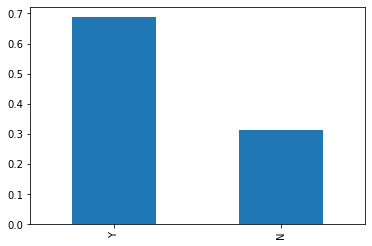

In [8]:
loan_train.Loan_Status.value_counts(), \
loan_train.Loan_Status.value_counts(normalize='True'), \
loan_train.Loan_Status.value_counts(normalize='True').plot(kind='bar')

We see that almost 70% of the loans are approved (422 of 614 applications in the dataset). The data imbalanced so we may explore later some options to rebalance.

#### 1.1.2 CATEGORICAL VARIABLES


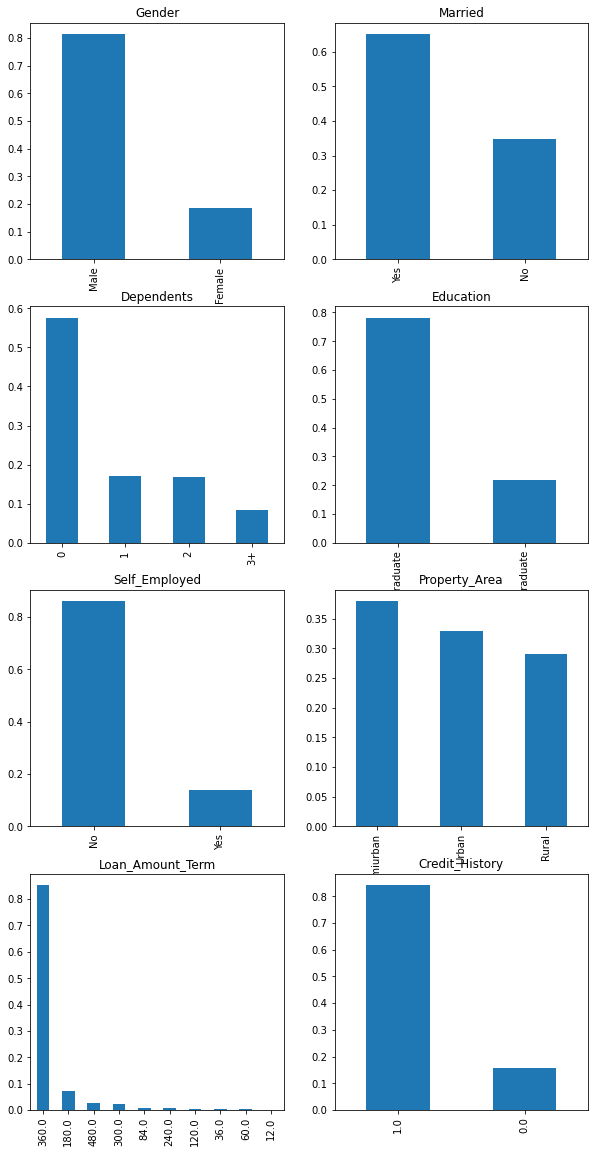

In [4]:
# Creating a boolean mask for categorical columns
categorical_mask = loan_train.dtypes == object
# Get list of categorical column names
cat_columns = loan_train.columns[categorical_mask].tolist()
#Add loan term and credit history as categorical and remove the target variable and the ID category from the list
cat_columns=cat_columns+['Loan_Amount_Term','Credit_History']
for i in ('Loan_ID','Loan_Status'): 
    cat_columns.remove(i)
    
#Plot distribution of categorical variables
for i in range(len(cat_columns)):
    plt.subplot(4,2,i+1)
    loan_train[cat_columns[i]].value_counts(normalize='True').plot(kind='bar',
              figsize=(10,20),title=cat_columns[i])
 
    

Majority of males (80%) and of married (65%) applicants. Also a wide predominancy of applicants with 0 dependents. Close to 80% graduates and only around 15% self employed. The distribution by property area is more evenly distributed between Semiurban (38%,), urban (32%) and rural (30%) .Regarding the loan term, the vast majority (85%) are 30 year term loans followed by far from 15 years mortgage (6%). Finally, the proportion of applicants with credit history is predominantly possitive (85 %).

To make sure that the distribution of the variables in the test set is similar to the training set, we generate the same plots with the test dataset.

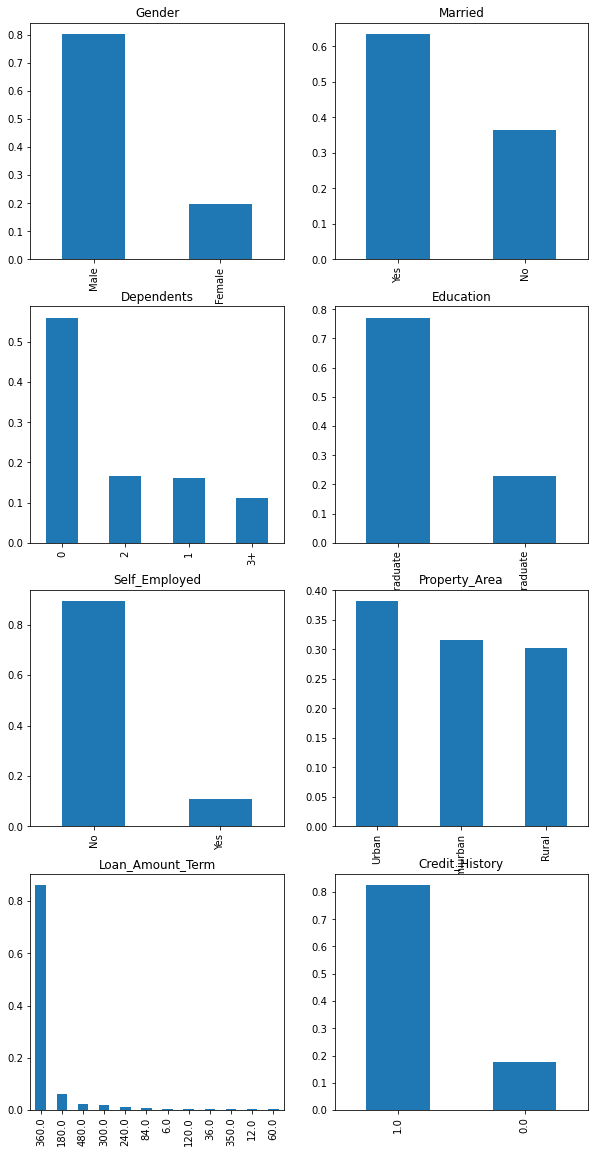

In [10]:
#Plot distribution of categorical variables in the test set
for i in range(len(cat_columns)):
    ax=plt.subplot(4,2,i+1)
    loan_test[cat_columns[i]].value_counts(normalize='True').plot(kind='bar',
              figsize=(10,20),title=cat_columns[i],ax=ax)   


We can appreciate a similar distribution than in the training set.
#### 1.1.3 NUMERICAL VARIABLES

In [5]:
# Create list of numerical column names. Remove Loan Amount Term and Credit History because we treat them as categorical
num_columns= loan_train.columns[~categorical_mask].tolist()
for i in ('Loan_Amount_Term','Credit_History'): 
    num_columns.remove(i)

num_columns

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

##### - Applicant Income

Applicant income mean is $5403
Applicant income median is $3812


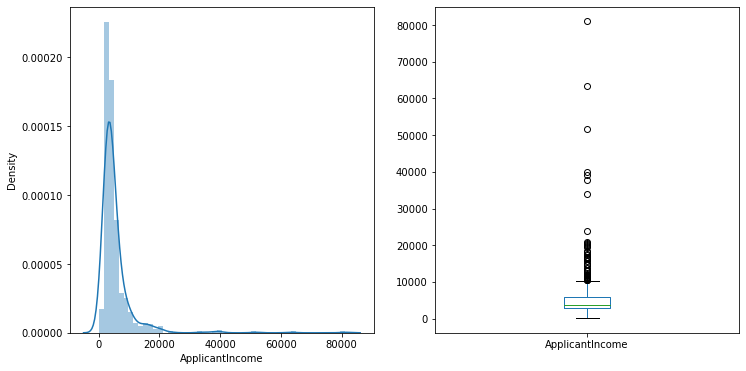

In [18]:

#Applicant Income distribution plot and boxplot
plt.figure(figsize=(12,6))
plt.subplot (1,2,1) 
sns.distplot(loan_train.ApplicantIncome)
plt.subplot (1,2,2) 
loan_train.ApplicantIncome.plot(kind='box')


print("Applicant income mean is $" + "{:.0f}".format(loan_train.ApplicantIncome.mean()))
print("Applicant income median is $" + "{:.0f}".format(loan_train.ApplicantIncome.median()))

We appreciate a clear left skewed distribution, with the mean significantly higher than the median (5403 vs 3812) and several extreme values.
Another way to evaluate the skewness of the income variables is using a probability plot. We plot the applicant income against a theoretical normal distribution. 

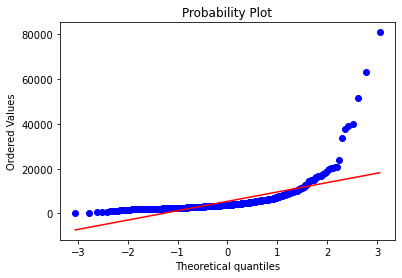

In [20]:
#Ploting a probability plot
res = stats.probplot(loan_train.ApplicantIncome, dist='norm',plot=plt)
plt.show()

##### - Coapplicant Income

Coapplicant income mean is $1621
Coapplicant income median is $1188


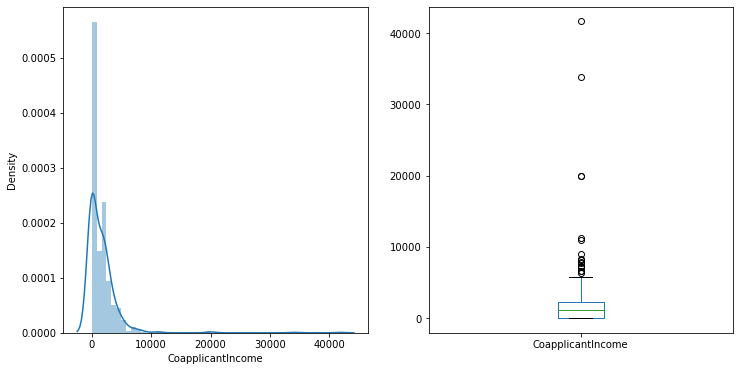

In [22]:
#Coapplicant Income distribution and boxplot
plt.figure(figsize=(12,6))
plt.subplot (1,2,1) 
sns.distplot(loan_train.CoapplicantIncome)
plt.subplot (1,2,2) 
loan_train.CoapplicantIncome.plot(kind='box')

print("Coapplicant income mean is $" + "{:.0f}".format(loan_train.CoapplicantIncome.mean()))
print("Coapplicant income median is $" + "{:.0f}".format(loan_train.CoapplicantIncome.median()))

We appreciate the same behaviour than in the applicant income case, with a left skewed distribution. 



##### - Loan Amount

Loan amount mean is $146
Loan amount median is $128


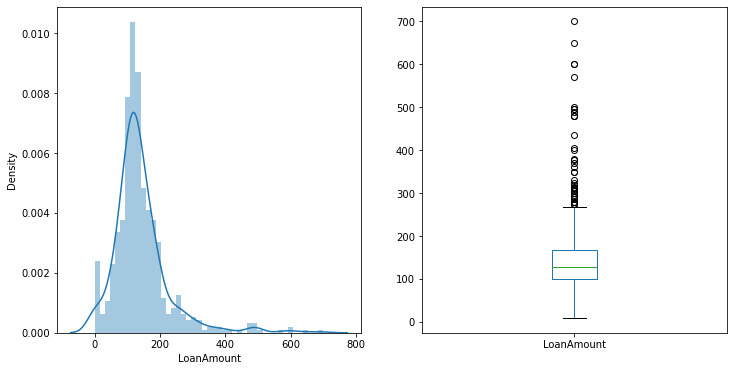

In [23]:
#Loan Amount distribution and boxplot
plt.figure(figsize=(12,6))
plt.subplot (1,2,1) 
sns.distplot(loan_train.LoanAmount.fillna(0))
plt.subplot (1,2,2) 
loan_train.LoanAmount.plot(kind='box')

print("Loan amount mean is $" + "{:.0f}".format(loan_train.LoanAmount.mean()))
print("Loan amount median is $" + "{:.0f}".format(loan_train.LoanAmount.median()))

Loan amount is closer to a normal distribution than the income variables, but still left skewed.

### 1.2 MULTIVARIATE ANALYSIS
#### 1.2.1 AGAINST TARGET VARIABLE
##### 1.2.1.1 CATEGORICAL VARIABLES

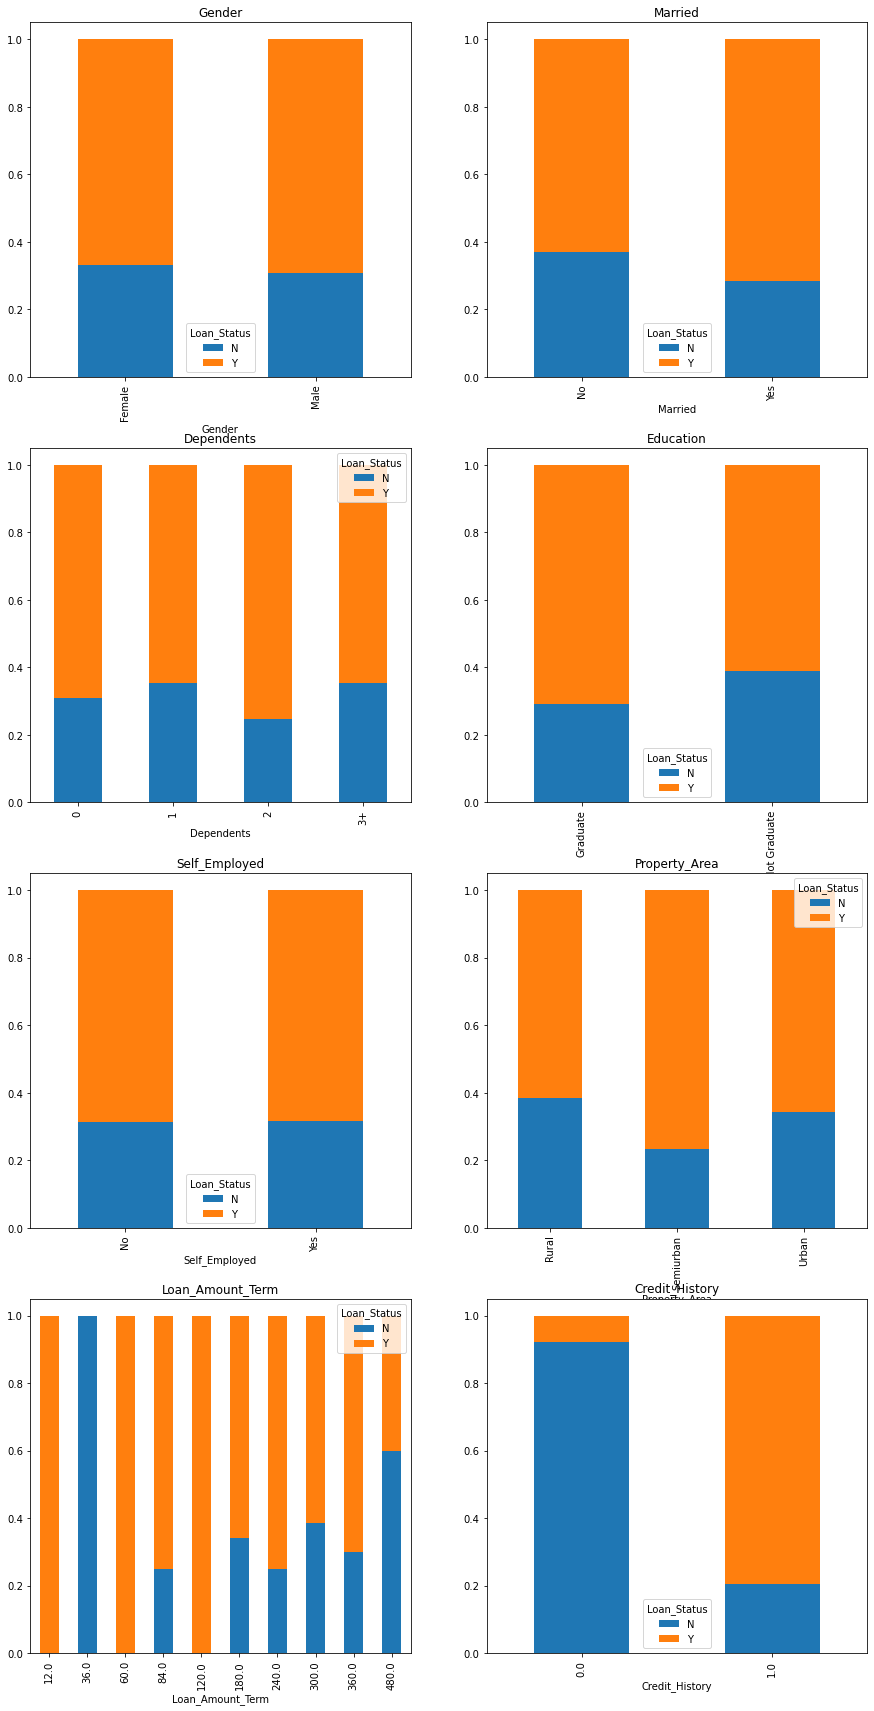

In [24]:
#Creating stacked bar charts of loan status agaisnt each categorical variable 
for i in range(len(cat_columns)):  
    crosstable_norm= pd.crosstab(loan_train[cat_columns[i]],loan_train.Loan_Status,normalize='index')
    ax=plt.subplot(4,2,i+1)
    crosstable_norm.plot(kind='bar',stacked='True',title=cat_columns[i],ax=ax,figsize=(15,30))

We see that the categorical variables that present more relation with Loan Status are Married, Education, Property Area and overwhelmingly, Credit History. The main takeaway is the weight that Credit History has in the approval decission, since more than 90% of applications without Credit History are rejected. 

Some of our initial intuitions are confirmed, such as the graduate applicants having a higher ratio of approval. However, we also see that self-employeed applicants do not to have a lower rate of approval as we expected.

To complement the analysis of the relation between the categorical variables and the target variable we can perform a chi independence test:

In [26]:
chi_values={}
list_chi=[]
for i in range(len(cat_columns)):  
    crosstable= pd.crosstab(loan_train[cat_columns[i]],loan_train.Loan_Status)
    chi,p,dof, ef= stats.chi2_contingency(crosstable)
    chi_values={'cat_1':cat_columns[i],'cat_2':'Loan_Status','chi':chi,'p':p,'dof':dof,'ef':ef}
    list_chi.append(chi_values)
    
df_chi=pd.DataFrame(list_chi)
print(df_chi[['cat_1','cat_2','p']])

              cat_1        cat_2       p
0            Gender  Loan_Status 0.70865
1           Married  Loan_Status 0.03439
2        Dependents  Loan_Status 0.36785
3         Education  Loan_Status 0.04310
4     Self_Employed  Loan_Status 0.94200
5     Property_Area  Loan_Status 0.00214
6  Loan_Amount_Term  Loan_Status 0.12186
7    Credit_History  Loan_Status 0.00000


Taking a p value of 5% as a reference, we confirm the results of the charts as we see that Married, Education, Property Area and above all, Credit History are the strongest related variables to Loan Status.

##### 1.2.1.2 NUMERICAL VARIABLES

<AxesSubplot:xlabel='Loan_Status'>

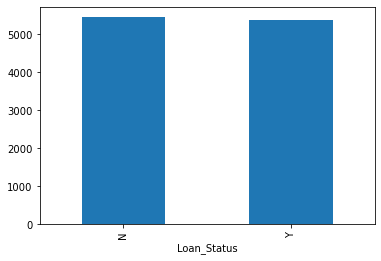

In [28]:
#ApplicantIncome
loan_train.groupby('Loan_Status').ApplicantIncome.mean().plot.bar()

The means of the applicants income for loan approved and not approved are similar. This goes against our intuition because we were expecting to see the approval rate to increase as the income increase. Anyways, using the mean can be misleading so we next will create bins to explore further the relationship.

0-2000         41
2000-2500      67
2500-3000      69
3000-3500      86
3500-4000      71
4000-4500      42
4500-5000      47
5000-6000      54
6000-7000      34
7000-10000     51
10000-81000    52
Name: ApplicantIncome, dtype: int64

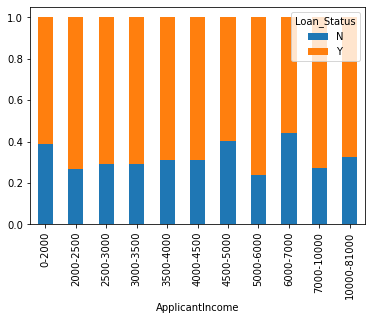

In [42]:
bins=[0,2000,2500,3000,3500,4000,4500,5000,6000,7000,10000,81000]
labels=[f'{i}-{j}' for i,j in zip(bins[:-1],bins[1:])]

'''Note: Neither the estimated standard deviation northe Freedman and Diaconis rule (
(bin width: W = 2 (IQR) N-1/3) worked to define the number of bins. The number of bins were manually adjusted the number of bins 
trying to have a comparable amount of values in each bin.'''

loan_train.ApplicantIncome_bin=pd.cut(loan_train.ApplicantIncome,bins,labels=labels)
pd.crosstab(loan_train.ApplicantIncome_bin,loan_train.Loan_Status,normalize='index').plot(kind='bar',stacked='True')
loan_train.ApplicantIncome_bin.value_counts(sort=False)


The lower bin 0-2000 has a higher percentage of rejection that the following bin. But then we see tht the bins of 4500 to 5000 and 6000 to 7000 have the higher proportion of rejections. We can't say that higher incomes have a higher ratio of approval.

We take now a look to te coapplicant income in a similar way.

<AxesSubplot:xlabel='Loan_Status'>

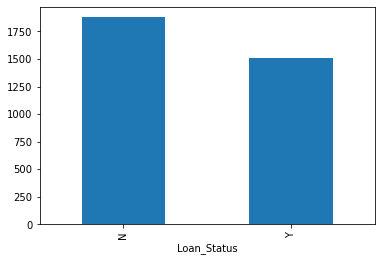

In [44]:
#Coapplicant Income
loan_train.groupby('Loan_Status').CoapplicantIncome.mean().plot.bar()

In this case, the results are even more surprising since we see that the mean of coaplicant income is higher for the rejected applications than for the approved ones.

0-500         279
500-1000       16
1000-1500      44
1500-2000      78
2000-2500      70
2500-3000      30
3000-3500      27
3500-4000      15
4000-4500      16
4500-5000       9
5000-6000      12
6000-7000       3
7000-42000     15
Name: CoapplicantIncome, dtype: int64

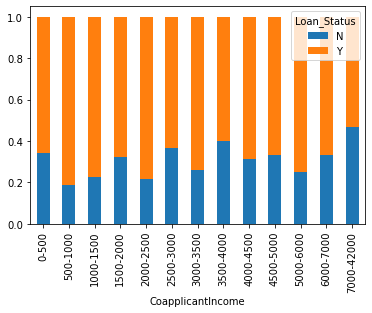

In [45]:
bins=[0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,6000,7000,42000]
labels=[f'{i}-{j}' for i,j in zip(bins[:-1],bins[1:])]

loan_train.CoapplicantIncome_bin=pd.cut(loan_train.CoapplicantIncome,bins,labels=labels,include_lowest=True)
pd.crosstab(loan_train.CoapplicantIncome_bin,loan_train.Loan_Status,normalize='index').plot(kind='bar',stacked='True')
loan_train.CoapplicantIncome_bin.value_counts(sort=False)


In the representation with bin we cannot appreciate a trend indicating that higher coapplicant incomes increase the chances of approval. Actually, there is no clear pattern.

<AxesSubplot:xlabel='Loan_Status'>

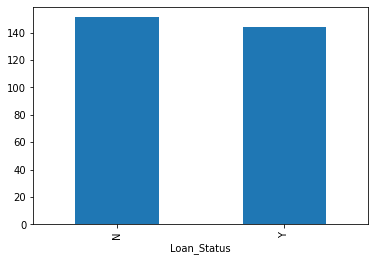

In [46]:
#LoanAmount
loan_train.groupby('Loan_Status').LoanAmount.mean().plot.bar()

0-25         4
25-50       19
50-75       46
75-100      85
100-125    134
125-150    104
150-175     70
175-250     78
250-700     52
Name: LoanAmount, dtype: int64

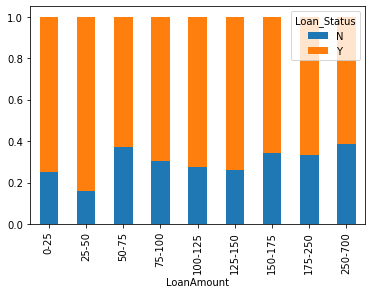

In [47]:
bins=[0,25,50,75,100,125,150,175,250,700]
labels=[f'{i}-{j}' for i,j in zip(bins[:-1],bins[1:])]

loan_train.LoanAmount_bin=pd.cut(loan_train.LoanAmount,bins,labels=labels,include_lowest=True)
pd.crosstab(loan_train.LoanAmount_bin,loan_train.Loan_Status,normalize='index').plot(kind='bar',stacked='True')
loan_train.LoanAmount_bin.value_counts(sort=False)


We can  appreciate that there are slighltly more rejections of the applications requesting higher loan amounts. In any case, the difference is small and does not allow to draw a solid conclussion.

As a general summary of the numerical variables, we can say that the independent analysis of each variable is not concluding. It only make sense to evaluate the response when combining the income variables with the loan amount . We will explore this later when we create a calculated variable (loan to income ratio)

#### 1.2.2 RELATION BETWEEN VARIABLES
We will now explore the relationship between the different variables in the dataset. For the numerical variables, we will use a pairplot and a heatmap. For the categorical, we will use a chi square test of independence.

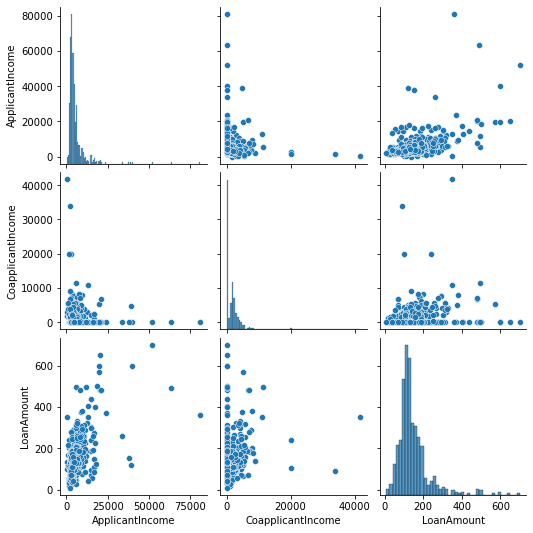

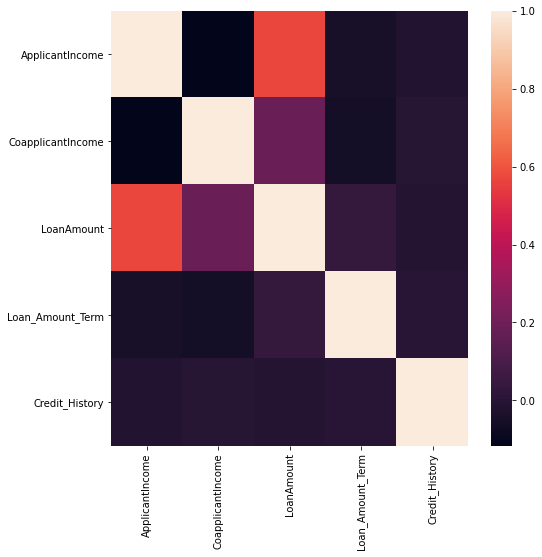

In [48]:
#Relation between numerical variables

sns.pairplot(loan_train,vars=num_columns,dropna=True)   
plt.figure(figsize=(8,8))
sns.heatmap(loan_train.corr())

plt.show()

We appreciate positive correlation between applicant income and loan amount. This was expected, since those applicants with higher income  will probably purchase more expensive properties. To a less extent, we see the same positive correlation between Coapplicant income and loan amount. Loan term and credit history do no present any significant correlation.

In [49]:
#Relation between categorical variables
chi_values={}
list_chi=[]
for i in range(len(cat_columns)):  
    for j in range(len(cat_columns)):  
        if j!=i:
            crosstable= pd.crosstab(loan_train[cat_columns[i]],loan_train[cat_columns[j]])
            chi,p,dof, ef= stats.chi2_contingency(crosstable)
            chi_values={'cat_1':cat_columns[i],'cat_2':cat_columns[j],'chi':chi,'p':p,'dof':dof,'ef':ef}
            list_chi.append(chi_values)
   
df_chi=pd.DataFrame(list_chi)
print(df_chi.loc[df_chi['p']<0.01,['cat_1','cat_2','p']])

         cat_1       cat_2       p
0       Gender     Married 0.00000
1       Gender  Dependents 0.00024
7      Married      Gender 0.00000
8      Married  Dependents 0.00000
14  Dependents      Gender 0.00024
15  Dependents     Married 0.00000


Taking as a reference a p value of 1% (p<0.01), we see that the stronger related variables are Gender-Married, Gender-Dependent and Married-Dependents

## 2. DATA TREATMENT
### 2.1 MISSING VALUES (Imputation)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


Text(0.5, 1.0, 'Percent missing data by feature')

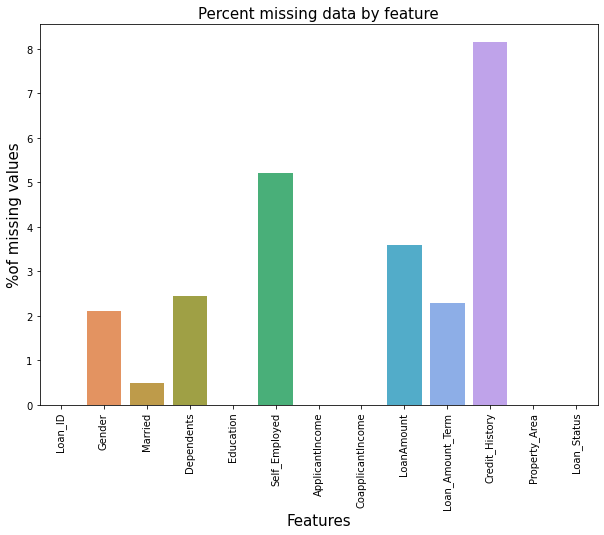

In [6]:
print(loan_train.isnull().sum())
null_percentage = (loan_train.isnull().sum() / len(loan_train)) * 100

plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
sns.barplot(x=null_percentage.index, y=null_percentage)
plt.xlabel('Features', fontsize=15)
plt.ylabel('%of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)


We see that there are several features with missing values. To deal with the missing values there are different strategies. One is just to get rid of all entries with missing values. But if we do that, we will eliminate a total 134 entries, which represents almost a 22% of the dataset. A second strategy is to treat the missing values as an additional category. And a third option is to we impute the missing values. We will use this third option starting by imputing single values. Perhaps later we will also consider multiple imputation methods.

In [7]:
#Gender imputation
loan_train.Gender.isnull().sum()

13

There are a total of 13 values null for gender. We have seen that 80% of the applicants in the dataset are male, so we could just impute the mode for the missing value. But since the dataset is not that large, it may be worth to take a closer look to the data and try to refine the imputation. From the EDA and the chi independent test we have identified Married, Dependents and Property_Area as correlated to gender. Let's first check the distribution of gender by marital status:


In [8]:
loan_train.groupby(['Gender','Married']).Gender.count()

Gender  Married
Female  No          80
        Yes         31
Male    No         130
        Yes        357
Name: Gender, dtype: int64

There are 111 applicants female vs 487 male.  Out of the total of married (388), 31 are female and 357 are male,meaning that only 8% of the married applicants  are female. So for all applicants with gender missing and married, it makes sense to impute male. 

For those applicants not married, let's now check  t variable 'Dependents' to see if we find a hint:


In [9]:
loan_train[loan_train['Married']=='No'].groupby(['Gender','Married','Dependents']).Gender.count()

Gender  Married  Dependents
Female  No       0              60
                 1              13
                 2               2
                 3+              3
Male    No       0             109
                 1              10
                 2               6
                 3+              3
Name: Gender, dtype: int64

Distribution by dependents is similar for both genders, with a clear predominance of 0 dependents for both genders. Therefore, we canot use the dependents to refine the gender imputation. Since we have not found any indication, we will just impute the mode for the gender missing values:

In [10]:
loan_train['Gender']=loan_train['Gender'].fillna(loan_train['Gender'].mode()[0])

In [11]:
#Married
loan_train.Married.isnull().sum()

3

There are just 3 missing values. In the dataset, 213 (35%) are not married and 398 (65%) are married.The most related variables to married are gender and dependents. But as we have just seen before, we can't use them to refine the estimate, so we will just impute the mode (married) to all three missing values.

In [12]:
loan_train['Married']=loan_train['Married'].fillna(loan_train['Married'].mode()[0])

In [13]:
#Dependents
loan_train.Dependents.isnull().sum()

15

Dependents variable has 15 missing values.Most realted variables are Married and Gender. If Married is No, we will impute 0 since represents alsmot 82% of the cases. When Married is yes, the distribution by gender does not allow to select 1,2 or +3 dependents over 0. So we will  impute the mode as well.


In [14]:
loan_train[loan_train['Married']=='Yes'].groupby(['Gender','Married','Dependents']).Gender.count()

Gender  Married  Dependents
Female  Yes      0              20
                 1               6
                 2               5
Male    Yes      0             154
                 1              73
                 2              88
                 3+             44
Name: Gender, dtype: int64

In [15]:
loan_train['Dependents']=loan_train['Dependents'].fillna(loan_train['Dependents'].mode()[0])

For Self_Employed and Laon_Amount_term there are 32 missing values and 14, respectively. Since we didn't find any associated variable, we will impute the mode for both,

In [16]:
loan_train[['Self_Employed','Loan_Amount_Term']].isnull().sum()

Self_Employed       32
Loan_Amount_Term    14
dtype: int64

In [17]:
loan_train['Self_Employed']=loan_train['Self_Employed'].fillna(loan_train['Self_Employed'].mode()[0])
loan_train['Loan_Amount_Term'].unique()

array([360., 120., 240.,  nan, 180.,  60., 300., 480.,  36.,  84.,  12.])

In the case of Loan term there are no missing values. However, we see that there are two mortgages with 36 months term and one with 12 months term.  Mortgages of 2 and 3 years are rare so we can suspect that actually is those values atea missing 0 an error and real values are 360 and 120 (30 and 10 years).In a real scenario, we will ask to the provider of the information to verify the values. However, since here we don't have a way to do the verification we will leave the values as they are.

In [18]:
loan_train.loc[(loan_train['Loan_Amount_Term']== 12) | (loan_train['Loan_Amount_Term']== 36)]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
262,LP001870,Female,No,1,Graduate,No,3481,0.00000,155.00000,36.00000,1.00000,Semiurban,N
497,LP002588,Male,Yes,0,Graduate,No,4625,2857.00000,111.00000,12.00000,nan,Urban,Y
546,LP002768,Male,No,0,Not Graduate,No,3358,0.00000,80.00000,36.00000,1.00000,Semiurban,N


In [19]:
loan_train['Loan_Amount_Term']=loan_train['Loan_Amount_Term'].fillna(loan_train['Loan_Amount_Term'].mode()[0])

In [35]:
#Credit History
loan_train['Credit_History'].isnull().sum()

50

50 missing credit history values.  85% od the applicants in the dataset have credit history, so assuming that the values with missing Credit History are random, if we impute the mode (credit History "yes") we have 85% chances to impute the right value. 

In [21]:
loan_train['Credit_History']=loan_train['Credit_History'].fillna(loan_train['Credit_History'].mode()[0])
#Note: tried imputation methods 

Lastly, for LoanAmount there are 22 missing values. Given that there are many extreme values in the dataset, we will replace the missing values with the median (146) rather than with the mean (128)

In [22]:
loan_train['LoanAmount']=loan_train['LoanAmount'].fillna(loan_train['LoanAmount'].median())

In [23]:
#Confirm there are no null values reamining
loan_train.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

### 2.2 Correct skewness

As we have seen before, all numerical variables (Applicant Income, CoApplicant Income and Loan Amount) have a positive skew. This can imply that some of the algorithms we will use later might be trained in a much larger number of moderate values than extreme values, resulting in a  model less likely to predict correctly the most extreme values. To correct this behaviour we will apply a log tranformation. 

Although we will work later in the feature engineering, it makes sense since the beginning to create a unique variable that combine both applicant and coapplicant incomes. To this combined variable we apply the log tranformation.


In [24]:
#Creating a Total income variable and applying a log transformation
loan_train['Total_Income']=loan_train['ApplicantIncome']+loan_train['CoapplicantIncome']
loan_train['Total_Income_log']=np.log(loan_train['Total_Income'])
loan_train['LoanAmount_log']=np.log(loan_train['LoanAmount'])

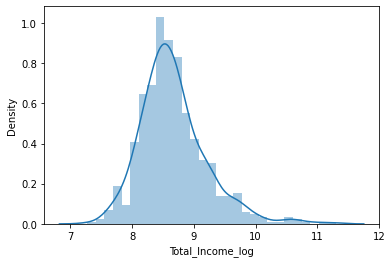

In [25]:
sns.distplot(loan_train['Total_Income_log'])
plt.show()

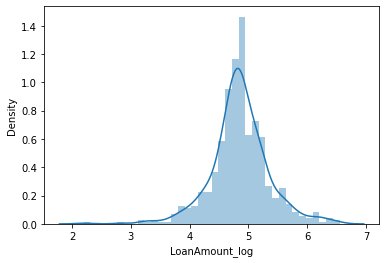

In [26]:
sns.distplot(loan_train['LoanAmount_log'])
plt.show()

As we see in the charts above, the skewness has been attenuated with the log transform.

### 2.3 Categorical into indicator variables (dummy variables)
The last step is to convert the categorical variables into dummy/indicator variables.


In [27]:
#Saving the ID of the records
loan_train_ID=loan_train.Loan_ID
loan_train.drop(['Loan_ID'],axis=1,inplace=True)
loan_train =pd.get_dummies(loan_train,drop_first=True)

## 3. MODEL

In [43]:
y=loan_train.Loan_Status_Y
X=loan_train.copy()
X.drop(['Loan_Status_Y'],axis=1,inplace=True)
#Dropping the original amount variables, since we will use the log transformed values
X.drop(['ApplicantIncome'],axis=1,inplace=True)
X.drop(['CoapplicantIncome'],axis=1,inplace=True)
X.drop(['Total_Income'],axis=1,inplace=True)
X.drop(['LoanAmount'],axis=1,inplace=True)

Since we have seen that the proportion of the approved class is significantly higher than the rejected class, we will apply a stratifield-kfold to keep the proportion in the splits.

In [44]:
kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42) 
#Creating a dataframe to store the results we are obtaining after applying different methods and alternatives. 
Results=pd.DataFrame(columns=['Algorithm', 'Model', 'Features','Best_Score_train','Best_Score_test','Case','Case_Descript'])

##### 3.1 Baseline: No Hyperparameter tuning, no Feature Engineering, no Feature Selection

In [7]:

#Algorithms
alg1=LogisticRegression()
alg2= SVC(probability=True)
alg3=KNeighborsClassifier()
alg4= DecisionTreeClassifier()
alg5= RandomForestClassifier()
alg6= xgb.XGBClassifier()

#Scaling the features for the logistic regression, SVC, KNeighbor and xgb. No need to scale for the tree based algorithms
pipe1 = Pipeline([('std', StandardScaler()),('classifier', alg1)])
pipe2 = Pipeline([('std', StandardScaler()),('classifier', alg2)])
pipe3 = Pipeline([('std', StandardScaler()),('classifier', alg3)])
pipe4 = Pipeline([('classifier', alg4)])
pipe5 = Pipeline([('classifier', alg5)])
pipe6 = Pipeline([('std', StandardScaler()),('classifier', alg6)])

pipelist= [pipe1,pipe2,pipe3,pipe4,pipe5,pipe6]

In [1439]:
for i,j in zip(pipelist,('Logreg','SVM', 'KNN', 'DTree','RF','XGB')):
     results_kfold = cross_validate(i, X, y, cv=kf,return_train_score=True,scoring='accuracy')
     Results.loc[len(Results)] = [j, results_kfold,'All original features',results_kfold['train_score'].mean(),
                                  results_kfold['test_score'].mean(),'Algorithm only','Original features. Log transform. No tunning, \
                                  No feature selection']


We see that after our first run the model that betters performs is based in a Decission Tree classifier, with almost 81% of accuracy in the test scoring. Next we will do a GridSearch to fine tune the algorithms parameters.

##### 3.2 Model with Hyperparameter tuning (Gridsearch), no Feature Engineering, no Feature Selection

In [254]:
#Gridsearch
Gridsearch={}

#Pipelines for GridSearch
pipegrid1 = Pipeline([('std', StandardScaler()),
                  ('alg1', alg1)])
pipegrid2 = Pipeline([('std', StandardScaler()),
                  ('alg2', alg2)])
pipegrid3 = Pipeline([('std', StandardScaler()),
                  ('alg3', alg3)])
pipegrid4=Pipeline([('alg4', alg4)])
pipegrid5= Pipeline([('alg5', alg5)])  
pipegrid6 = Pipeline([('std', StandardScaler()),
                     ('alg6', alg6)])
#Hyper paramaeter grids for the gridsearch.    
param_grid1 = {'alg1__solver':['lbfgs', 'liblinear'],'alg1__penalty': ['l2'],'alg1__C': [0.001,0.01,0.1,1,10,100]} #np.power(10., np.arange(-4, 4)
param_grid2 = {'alg2__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'alg2__C': [0.001,0.01,0.1,1,10,100],
                'alg2__gamma': np.power(10., np.arange(-5, 0)),'alg2__decision_function_shape' : ['ovo', 'ovr']}
param_grid3 = {'alg3__n_neighbors': list(range(1, 10)),'alg3__p': [1, 2]}
param_grid4 = {'alg4__max_depth': list(range(1, 10)) + [None],'alg4__criterion': ['gini', 'entropy']}
param_grid5 = {'alg5__max_depth': list(range(1, 20, 2)), 'alg5__n_estimators': 
    list(range(1, 200, 20)),'alg5__max_features' : list(range(1,4,1))}
param_grid6 = {'alg6__subsample': np.arange(.05, 1, .05),
                  'alg6__max_depth': np.arange(3,20,1),
                  'alg6__colsample_bytree': np.arange(.1,1.05,.05)}

pipegridlist= [pipegrid1,pipegrid2,pipegrid3,pipegrid4,pipegrid5,pipegrid6]
paramgridlist=[param_grid1,param_grid2,param_grid3,param_grid4,param_grid5,param_grid6]

In [1443]:
start_time = time.time()
for i,j,k in zip(pipegridlist,paramgridlist,('Logreg','SVM', 'KNN', 'DTree','RF','XGB')):
    grid = GridSearchCV(i, j, cv=kf,scoring='accuracy',return_train_score='True')
    grid.fit(X,y)
    Gridsearch[k]= grid
print("--- %s seconds ---" % (time.time() - start_time))
    

--- 5469.3817093372345 seconds ---


In [1445]:
for algorithm,gridresults in Gridsearch.items():
    Results.loc[len(Results)] = [algorithm, gridresults,'All original features',
                                     gridresults.cv_results_['mean_train_score'][gridresults.best_index_],
                                     gridresults.cv_results_['mean_test_score'][gridresults.best_index_],'Gridsearch','Original features.\
                                     Log transform. No tunning, No feature selection']

In [1446]:
Results

,Algorithm,Model,Features,Best_Score_train,Best_Score_test,Case,Case_Descript
0,Logreg,"{'fit_time': [0.005984783172607422, 0.00398969...",All original features,0.80981,0.80807,Algorithm only,"Original features. Log transform. No tunning, ..."
1,SVM,"{'fit_time': [0.04188656806945801, 0.039890527...",All original features,0.82067,0.80648,Algorithm only,"Original features. Log transform. No tunning, ..."
2,KNN,"{'fit_time': [0.003961086273193359, 0.00398921...",All original features,0.81940,0.76073,Algorithm only,"Original features. Log transform. No tunning, ..."
3,DTree,"{'fit_time': [0.002991199493408203, 0.00299572...",All original features,1.00000,0.70526,Algorithm only,"Original features. Log transform. No tunning, ..."
4,RF,"{'fit_time': [0.016953229904174805, 0.01699161...",All original features,0.98642,0.75280,Algorithm only,"Original features. Log transform. No tunning, ..."
5,XGB,"{'fit_time': [0.04692530632019043, 0.044829130...",All original features,0.86193,0.80325,Algorithm only,"Original features. Log transform. No tunning, ..."
6,Logreg,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80945,0.80945,Gridsearch,Original features. ...
7,SVM,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80945,0.80945,Gridsearch,Original features. ...
8,KNN,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80149,0.78339,Gridsearch,Original features. ...
9,DTree,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80945,0.80945,Gridsearch,Original features. ...


After tunning the algorithm hyper parameters,  the accuracy of the Random Forest and XGB has improved, while there is no improvement in the the rest of the algorithms. Since the gridsearch has performed and exhaustive search of the hyper parameters, it has taken more the 47 minutes to get the results. Let's try next a Randomized search to see if we can get similar results in a reduce computation time. 

##### 3.3 Model with Hyperparameter tuning (Randomized Search), no Feature Engineering, no Feature Selection

In [121]:
Randomizedsearch={}

start_time = time.time()
for i,j,k in zip(pipegridlist,paramgridlist,('Logreg','SVM', 'KNN', 'DTree','RF','XGB')):
    rgrid = RandomizedSearchCV(i, j, cv=kf,n_iter=10,n_jobs=-1,return_train_score='True',scoring='accuracy',refit=True)
    rgrid.fit(X,y)
    Randomizedsearch[k]= rgrid
print("--- %s seconds ---" % (time.time() - start_time))



--- 17.059215545654297 seconds ---


In [1462]:
for algorithm,gridresults in Randomizedsearch.items():
    Results.loc[len(Results)] = [algorithm, gridresults,'All original features',
                                     gridresults.cv_results_['mean_train_score'][gridresults.best_index_],
                                     gridresults.cv_results_['mean_test_score'][gridresults.best_index_],'Randomizedsearch','Original features.\
                                     Log transform. No tunning, No feature selection']  

In [49]:
Results

,Algorithm,Model,Features,Best_Score_train,Best_Score_test,Case,Case_Descript


In [1465]:
#Getting the parameters of the best model
Results['Model'][10].best_estimator_.steps[0][1]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=81,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [1464]:
Results.to_pickle('C:/Users/lcast/Desktop/DS/Projects/Training/Loan Prediction/Results.pkl')

We can now take a look to the importance of each of the features of our best model.

Text(0.5, 1.0, 'Feature Importance-RFC')

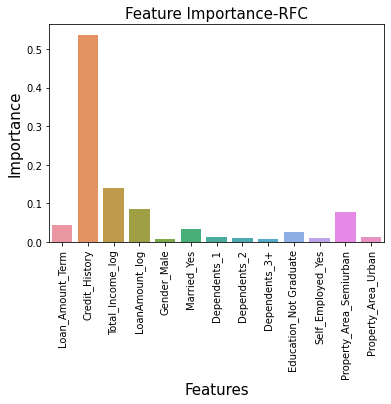

In [1466]:
#Retrieving the feature importance using the feature_importances. We can do the same for DT and XGB based models.
#For logistic regression and SVM we can just take a loo to the coeficient magnitude
Feature_Importance=Results['Model'][10].best_estimator_.steps[0][1].feature_importances_ #RFC
#Results['Model'][9].best_estimator_.steps[0][1].feature_importances_ #DT
#Results['Model'][6].best_estimator_.steps[1][1].coef_ #Logreg
#Results['Model'][7].best_estimator_.steps[1][1].coef_ #SVM
#Results['Model'][11].best_estimator_.steps[1][1].feature_importances_ #xgb

plt.xticks(rotation='90')
sns.barplot(x=X.columns, y=Feature_Importance)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Importance', fontsize=15)
plt.title('Feature Importance-RFC', fontsize=15)

By a long shoot, credit history is the feature with moreweight, with aroung 70% of the importance.



##### 3.4  Feature Engineering
We will now do some feature engineering and create new feature to see if we can improve the accuracy of the model. In particular, we are going to create the following additional features:

- Loan Amount to Total Income Ratio. Which percentage of the applicant monthly income is dedicated to pay the loan.
- Equated Monthly Installment (EMI). Monthly loan payment that includes the interest amount. o calculate it, we use the following formula: 
               EMI=B*(r(1+r)^n)/((1+r)^n-1) where B is balance, r montly interest, is the number of payments. We don't know the monthly interest. We will considerer a flat interest of 5% for all the applications.
                                       
                                       
- EMI to Total Income Ratio. Similar to Loan Amount to Total Income Ratio, but using the calculated EMI
- Has Coapplicant?. Boolean variable that just indicates is the application has a coapllicant or not.

In [46]:
#Calculated variable 1: Ratio loan to total_Income
#Convert Loan Amount from k to unit.
loan_train['Loan_to_income']=np.round(loan_train['Total_Income'].div(loan_train['LoanAmount'].mul(1000).div(loan_train['Loan_Amount_Term'])))
loan_train['Loan_to_income_log']=np.log(loan_train['Loan_to_income'])

#Calculated variable 2:Equated Monthly Payment (EMI). Apply log transform to reduce the skewness
#Formula M=B*(r(1+r)^n)/((1+r)^n-1)
#M is your monthly payment.
#B is balance
#r is your monthly interest rate 5%=>  5/12/100
#n is your number of payments (the number of months you will be paying the loan)
ir=0.05
mir=ir/12
loan_train['EMI']= loan_train['LoanAmount']*1000*((mir*(1+mir)**loan_train['Loan_Amount_Term'])/((1+mir)**loan_train['Loan_Amount_Term']-1))
loan_train['EMI_log']=np.log(loan_train['EMI'])

#Calculated variable 3: Ratio Equated Monthly Payment (EMI) to Total_Income.Apply log transform to reduce the skewness
loan_train['EMI_to_income']=np.round(loan_train['Total_Income'].div(loan_train['EMI']))
loan_train['EMI_to_income_log']=np.log(loan_train['EMI_to_income'])

#Calculated variable 4: Has codependent
loan_train['CoApplicant?']=np.where(loan_train['CoapplicantIncome']>0,1,0)


In [47]:
y=loan_train.Loan_Status_Y
X=loan_train.copy()
X.drop(['ApplicantIncome','CoapplicantIncome','LoanAmount','Total_Income','Loan_Status_Y','Loan_to_income','EMI','EMI_to_income',],axis=1,inplace=True)
X.columns

Index(['Loan_Amount_Term', 'Credit_History', 'Total_Income_log',
       'LoanAmount_log', 'Gender_Male', 'Married_Yes', 'Dependents_1',
       'Dependents_2', 'Dependents_3+', 'Education_Not Graduate',
       'Self_Employed_Yes', 'Property_Area_Semiurban', 'Property_Area_Urban',
       'Loan_to_income_log', 'EMI_log', 'EMI_to_income_log', 'CoApplicant?'],
      dtype='object')

##### 3.5 Model with Hyperparameter tuning (Gridsearch Search), Feature Engineering, no Feature Selection

In [1487]:
start_time = time.time()
for i,j,k in zip(pipegridlist,paramgridlist,('Logreg','SVM', 'KNN', 'DTree','RF','XGB')):
    grid = GridSearchCV(i, j, cv=kf,scoring='accuracy',return_train_score='True')
    grid.fit(X,y)
    Gridsearch[k]= grid
print("--- %s seconds ---" % (time.time() - start_time))

--- 12949.478688716888 seconds ---


In [1488]:
for algorithm,gridresults in Gridsearch.items():
    Results.loc[len(Results)] = [algorithm, gridresults,'All original features plus calculated features',
                                     gridresults.cv_results_['mean_train_score'][gridresults.best_index_],
                                     gridresults.cv_results_['mean_test_score'][gridresults.best_index_],'Gridsearch','Original and calculated features.\
                                     Log transform. Gridsearch, No feature selection']  

In [48]:
Results

,Algorithm,Model,Features,Best_Score_train,Best_Score_test,Case,Case_Descript


In [ ]:
Results.to_pickle('C:/Users/lcast/Desktop/DS/Projects/Training/Loan Prediction/Results.pkl')
#Results.drop(Results.index[[24,25,26,27,28]],inplace=True)
#Results=pd.read_pickle('C:/Users/lcast/Desktop/DS/Projects/Training/Loan Prediction/Results.pkl')

Some improvement of RF and XGB based models if we compared against the accuracy obtained with the Gridsearch without calculated features. No improvement in the cases of logistic regression and SVM.

Text(0.5, 1.0, 'Feature Importance-XGBC')

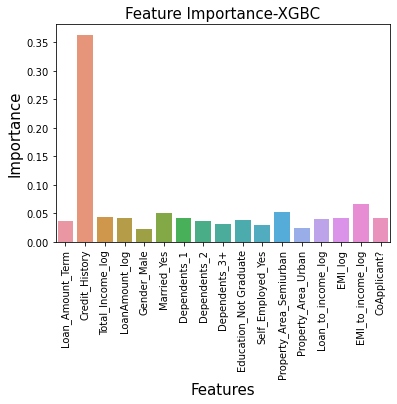

In [1545]:
#Retrieving the feature importance using the feature_importances. We can do the same for DT and XGB based models.
#For logistic regression and SVM we can just take a loo to the coeficient magnitude
Feature_Importance=Results['Model'][23].best_estimator_.steps[1][1].feature_importances_ #XGBC

plt.xticks(rotation='90')
sns.barplot(x=X.columns, y=Feature_Importance)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Importance', fontsize=15)
plt.title('Feature Importance-XGBC', fontsize=15)

Checking the feature importance for the RFC based model, we see that while Credit History appears as the most important feature, some of the calculated features also are contributing to the model prediction capability. 

##### 3.6 Feature selection

Let's take one step further and perform a feature selection. "The objective of variable selection is three-fold: improving the prediction performance of the predictors, providing faster and more cost-effective predictors, and providing a better understanding of the underlying process that generated the data." (*from An Introduction to Variable and Feature Selection, Journal of Machine Learning Research 3 (2003) 1157-1182)

We will use the following methods of feature selection:
- Univariate feature selection, which works by selecting the best features based on univariate statistical tests.
- Selection from model. Model based selection which uses coeficient or feature importance attributes of the estimators.
- Recursive feature elimination. Similar to selection from model,  select features by recursively considering smaller and smaller sets of features based on feature importances / coefficients
- Exhaustive Feature Selection, is a wrapper approach for brute-force evaluation of feature subsets. . For instance, if the classifier is a logistic regression and the dataset consists of 4 features, the alogorithm will evaluate all 15 feature combinations

In [57]:
#Creating a DataFrame to store the results of the different FS methodsl
Features_Rank=pd.DataFrame(index=X.columns.values)

##### 3.6.1 Feature selection method: SelectKBest

In [58]:
#a)Feature selection method: SelectKBest
#Univariate feature selection works by selecting the best features based on univariate statistical tests
    #For regression: f_regression, mutual_info_regression
    #For classification: chi2, f_classif, mutual_info_classif
kbest_test={'chi2': chi2,'f_classif': f_classif,'mutual_info_classif':mutual_info_classif}
for key,value in kbest_test.items():
    selector = SelectKBest(value)
    selector.fit_transform(X, y)
    Features_Rank[key]=selector.get_support()

In [59]:
Features_Rank

,chi2,f_classif,mutual_info_classif
Loan_Amount_Term,True,False,False
Credit_History,True,True,True
Total_Income_log,False,False,False
LoanAmount_log,False,True,False
Gender_Male,False,False,False
Married_Yes,True,True,True
Dependents_1,True,True,False
Dependents_2,True,True,False
Dependents_3+,True,False,False
Education_Not Graduate,True,True,True


##### 3.6.2 Feature selection method: SelectFromModel

In [61]:
alg1=LogisticRegression()
alg2= SVC(kernel='linear')#Only linear has coef_ attribute
#alg3=KNeighborsClassifier() No coefficient in this model
alg4= DecisionTreeClassifier()
alg5= RandomForestClassifier()
alg6= xgb.XGBClassifier()

alglist= [alg1,alg2,alg4,alg5,alg6]

for alg,name in zip(alglist,('Logreg','SVM', 'DTree','RF','XGB')):
    selector = SelectFromModel(alg)
    selector.fit(X, y)
    Features_Rank['SelectFromModel_'+ name]=selector.get_support()

In [61]:
Features_Rank

,chi2,f_classif,mutual_info_classif,SelectFromModel_Logreg,SelectFromModel_SVM,SelectFromModel_DTree,SelectFromModel_RF,SelectFromModel_XGB
Loan_Amount_Term,True,False,False,False,False,False,False,False
Credit_History,True,True,True,True,True,True,True,True
Total_Income_log,False,False,False,False,False,True,True,False
LoanAmount_log,False,True,False,False,False,True,True,False
Gender_Male,False,False,False,False,False,False,False,False
Married_Yes,True,True,True,True,False,False,False,False
Dependents_1,True,True,False,False,False,False,False,False
Dependents_2,True,True,False,False,False,False,False,False
Dependents_3+,True,False,False,False,False,False,False,False
Education_Not Graduate,True,True,True,False,False,False,False,False


##### 3.6.3 Feature selection method: RFECV. Additionally,estimation of the accuracyy of the model with the selected features

In [62]:
alg1=LogisticRegression()
alg2= SVC()
alg3=KNeighborsClassifier()
alg4= DecisionTreeClassifier()
alg5= RandomForestClassifier()
alg6= xgb.XGBClassifier()


kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42) 

scaler=StandardScaler()

pipe1 = Pipeline([('std', StandardScaler()),('selector', RFECV(alg1, step=1,scoring='accuracy'))])
pipe2 = Pipeline([('std', StandardScaler()),('selector', RFECV(alg2, step=1,scoring='accuracy'))])
#pipe3 = Pipeline([('std', StandardScaler()),('alg',alg3)])#No RFE in KNN
pipe4 = Pipeline([('selector', RFECV(alg4, step=1,scoring='accuracy'))])
pipe5 = Pipeline([('selector', RFECV(alg5, step=1,scoring='accuracy'))])
pipe6 = Pipeline([('std', StandardScaler()),('selector', RFECV(alg6, step=1,scoring='accuracy'))])

param_grid1 = {'selector__estimator__solver':['lbfgs', 'liblinear'],'selector__estimator__penalty': ['l2'],'selector__estimator__C': [0.001,0.01,0.1,1,10,100]}
param_grid2 = {'selector__estimator__kernel': ['linear'], 'selector__estimator__C': [0.001,0.01,0.1,1,10,100],
                'selector__estimator__gamma': np.power(10., np.arange(-5, 0)),'selector__estimator__decision_function_shape' : ['ovo', 'ovr']}
#param_grid3 = {'alg__n_neighbors': list(range(1, 10)),'alg__p': [1, 2]}
param_grid4 = {'selector__estimator__max_depth': list(range(1, 10)) + [None],'selector__estimator__criterion': ['gini', 'entropy']}
param_grid5 = {'selector__estimator__max_depth': list(range(1, 20, 2)), 'selector__estimator__n_estimators': 
    list(range(1, 200, 20))}
param_grid6 = {'selector__estimator__subsample': np.arange(.05, 1, .05),
                  'selector__estimator__max_depth': np.arange(3,20,1),
                  'selector__estimator__colsample_bytree': np.arange(.1,1.05,.05)}

pipelist= [pipe1,pipe2,pipe4,pipe5,pipe6]
paramlist=[param_grid1,param_grid2,param_grid4,param_grid5,param_grid6]


start_time = time.time()
for i,j,k in zip(pipelist,paramlist,('Logreg','SVC','DTree','RF','XGB')):
    rgrid_rfe = RandomizedSearchCV(i, j, cv=kf,n_jobs=-1,scoring='accuracy',refit=True)
    rgrid_rfe .fit(X,y)    
    if k in ('DTree','RF'):
        selected_features=rgrid_rfe.best_estimator_.steps[0][1].get_support()
        Features_Rank['RFECV_'+ k]=selected_features
    else:
        selected_features=rgrid_rfe.best_estimator_.steps[1][1].get_support()
        Features_Rank['RFECV_'+ k]=selected_features     
    Results.loc[len(Results)] = [k, rgrid_rfe,selected_features,'-',rgrid_rfe.best_score_,'RFECV','Original and calculated features.\
                                     Log transform. REFCV, Recursive Feature Elimination'] 
print("--- %s seconds ---" % (time.time() - start_time))

--- 1114.6546339988708 seconds ---


In [61]:
Results

,Algorithm,Model,Features,Best_Score_train,Best_Score_test,Case,Case_Descript
0,Logreg,"{'fit_time': [0.005984783172607422, 0.00398969...",All original features,0.80981,0.80807,Algorithm only,"Original features. Log transform. No tunning, ..."
1,SVM,"{'fit_time': [0.04188656806945801, 0.039890527...",All original features,0.82067,0.80648,Algorithm only,"Original features. Log transform. No tunning, ..."
2,KNN,"{'fit_time': [0.003961086273193359, 0.00398921...",All original features,0.81940,0.76073,Algorithm only,"Original features. Log transform. No tunning, ..."
3,DTree,"{'fit_time': [0.002991199493408203, 0.00299572...",All original features,1.00000,0.70526,Algorithm only,"Original features. Log transform. No tunning, ..."
4,RF,"{'fit_time': [0.016953229904174805, 0.01699161...",All original features,0.98642,0.75280,Algorithm only,"Original features. Log transform. No tunning, ..."
5,XGB,"{'fit_time': [0.04692530632019043, 0.044829130...",All original features,0.86193,0.80325,Algorithm only,"Original features. Log transform. No tunning, ..."
6,Logreg,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80945,0.80945,Gridsearch,Original features. ...
7,SVM,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80945,0.80945,Gridsearch,Original features. ...
8,KNN,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80149,0.78339,Gridsearch,Original features. ...
9,DTree,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80945,0.80945,Gridsearch,Original features. ...


In [1563]:
Features_Rank.to_pickle('C:/Users/lcast/Desktop/DS/Projects/Training/Loan Prediction/Features_Rank.pkl')
Results.to_pickle('C:/Users/lcast/Desktop/DS/Projects/Training/Loan Prediction/Results.pkl')

In [63]:
Features_Rank

,chi2,f_classif,mutual_info_classif,SelectFromModel_Logreg,SelectFromModel_SVM,SelectFromModel_DTree,SelectFromModel_RF,SelectFromModel_XGB,RFECV_Logreg,RFECV_SVC,RFECV_DTree,RFECV_RF,RFECV_XGB
Loan_Amount_Term,True,False,False,False,False,False,False,False,False,False,False,True,False
Credit_History,True,True,True,True,True,True,True,True,True,True,True,True,True
Total_Income_log,False,False,False,False,False,True,True,False,False,False,False,True,False
LoanAmount_log,False,True,False,False,False,True,True,False,False,False,False,True,False
Gender_Male,False,False,False,False,False,False,False,False,False,False,False,False,False
Married_Yes,True,True,True,True,False,False,False,False,False,False,False,False,False
Dependents_1,True,True,False,False,False,False,False,False,False,False,False,False,False
Dependents_2,True,True,False,False,False,False,False,False,False,False,False,False,False
Dependents_3+,True,False,False,False,False,False,False,False,False,False,False,False,False
Education_Not Graduate,True,True,True,False,False,False,False,False,False,False,False,False,False


In [32]:
 Features_Rank.sum(axis=1)

NameError: name 'Features_Rank' is not defined

We can see that the univariate selection methods tend to select much more features, while the other methods are more restrictive.
Credit history is selected by all the methods, proving the importance of this feature. We also see that "CoApplicant?" feature we have created has certain importance and in fact has been selected by six of the seven exhaustive feature selection we have performed.

##### 3.6.4 Feature selection method: Exhaustive Feature Selection (EFS) & Model with Hyperparameter tuning (Gridsearch Search), Feature Engineering, and REFCV Feature Selection 
Let's now calculate  the accuracy of a model using just the features selected by the EFS method. Since EFS calculate all the possible combinations of the maximum numbers of features selected, it's computationally expensive so we will pre-select the features that have resulted
more significant so far.

In [56]:
X_=X[['Credit_History','Total_Income_log','LoanAmount_log','Married_Yes','Property_Area_Semiurban','Loan_to_income_log', \
      'EMI_log','EMI_to_income_log','CoApplicant?']]

In [227]:
Features_Rank_=pd.DataFrame(index=X_.columns.values)

In [230]:
start_time = time.time()
for i,j in zip(alglist,('Logreg','SVM', 'KNN', 'DTree','RF','XGB')):
    efs=EFS(i, min_features=1,max_features=5,scoring='accuracy',
            clone_estimator=False,print_progress=False,cv=5,n_jobs=1)
    efs=efs.fit(X_,y)
    selected_features= np.zeros(X_.shape[1], bool)#Size of X, all false
    selected_features[np.array(efs.best_idx_)]=True #to fill missing index with NaN
    Features_Rank_['EFS_'+ j]=selected_features
print("--- %s seconds ---" % (time.time() - start_time))   


--- 151.0797679424286 seconds ---


In [ ]:
Features_Rank=pd.concat([Features_Rank,Features_Rank_],axis=1)

##### 3.5 Model with Hyperparameter tuning (Gridsearch Search), Feature Engineering, and EFS Feature Selection

In [52]:
del param_grid5['alg5__max_features'] #max features is given by the feateures selected in EFS
alglist= [alg1,alg2,alg3,alg4,alg5,alg6]
pipegridlist= [pipegrid1,pipegrid2,pipegrid3,pipegrid4,pipegrid5,pipegrid6]
paramgridlist=[param_grid1,param_grid2,param_grid3,param_grid4,param_grid5,param_grid6]

##Gridsearch for EFS 

start_time = time.time()
for i,j,k in zip(pipegridlist,paramgridlist,['Logreg','SVM', 'KNN', 'DTree','RF','XGB']):
    X_fs=X_[Features_Rank_.index[Features_Rank_['EFS_'+ k]]]
    rgrid = GridSearchCV(i, j, cv=kf,return_train_score='True',scoring='accuracy',refit=True)
    rgrid.fit(X_fs,y)
    Gridsearch[k]= rgrid
print("--- %s seconds ---" % (time.time() - start_time))

for algorithm,gridresults in Gridsearch.items():
    Results.loc[len(Results)] = [algorithm, gridresults,'EFS',
                                    gridresults.cv_results_['mean_train_score'][gridresults.best_index_],
                                     gridresults.cv_results_['mean_test_score'][gridresults.best_index_],'EFS and Gridsearch',\
                                     'Original and calculated features.Log transform. EFS plus Gridsearch'] 

In [271]:

Results.to_pickle('C:/Users/lcast/Desktop/DS/Projects/Training/Loan Prediction/Results.pkl')
Features_Rank.to_pickle('C:/Users/lcast/Desktop/DS/Projects/Training/Loan Prediction/Features_Rank.pkl')

In [ ]:
Features_Rank

##### 3.6 Model results analysis

Now we have all the accuracy scoring for all the models, we can take a look and compare the results:

- Full list of results:

In [55]:
Results


,Algorithm,Model,Features,Best_Score_train,Best_Score_test,Case,Case_Descript
0,Logreg,"{'fit_time': [0.005984783172607422, 0.00398969...",All original features,0.80981,0.80807,Algorithm only,"Original features. Log transform. No tunning, ..."
1,SVM,"{'fit_time': [0.04188656806945801, 0.039890527...",All original features,0.82067,0.80648,Algorithm only,"Original features. Log transform. No tunning, ..."
2,KNN,"{'fit_time': [0.003961086273193359, 0.00398921...",All original features,0.81940,0.76073,Algorithm only,"Original features. Log transform. No tunning, ..."
3,DTree,"{'fit_time': [0.002991199493408203, 0.00299572...",All original features,1.00000,0.70526,Algorithm only,"Original features. Log transform. No tunning, ..."
4,RF,"{'fit_time': [0.016953229904174805, 0.01699161...",All original features,0.98642,0.75280,Algorithm only,"Original features. Log transform. No tunning, ..."
5,XGB,"{'fit_time': [0.04692530632019043, 0.044829130...",All original features,0.86193,0.80325,Algorithm only,"Original features. Log transform. No tunning, ..."
6,Logreg,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80945,0.80945,Gridsearch,Original features. ...
7,SVM,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80945,0.80945,Gridsearch,Original features. ...
8,KNN,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80149,0.78339,Gridsearch,Original features. ...
9,DTree,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80945,0.80945,Gridsearch,Original features. ...


Features selection has not helped to improve our best accuracy so far. Is worth mentioning that a model with a single feature accuracy is no so below a model based in more features.

- Top 2 models of each algorithm:

In [53]:
#Select Top 2 of each algorithm
Results[['Algorithm','Best_Score_test','Case']].groupby('Algorithm',sort=False).apply(lambda x:x.sort_values(by='Best_Score_test',ascending=False).head(2))

Algorithm  Best_Score_test                Case
Algorithm                                                  
Logreg    6     Logreg          0.80945          Gridsearch
          12    Logreg          0.80945    Randomizedsearch
SVM       7        SVM          0.80945          Gridsearch
          13       SVM          0.80945    Randomizedsearch
KNN       32       KNN          0.81270  EFS and Gridsearch
          20       KNN          0.78502          Gridsearch
DTree     9      DTree          0.80945          Gridsearch
          15     DTree          0.80945    Randomizedsearch
RF        22        RF          0.81433          Gridsearch
          10        RF          0.81107          Gridsearch
XGB       23       XGB          0.82085          Gridsearch
          11       XGB          0.81107          Gridsearch
SVC       25       SVC          0.80945               RFECV

- Top 10:

In [54]:
Results[['Algorithm','Best_Score_test','Case','Features']].sort_values(by='Best_Score_test',ascending=False).head(10)

,Algorithm,Best_Score_test,Case,Features
23,XGB,0.82085,Gridsearch,All original features plus calculated features
22,RF,0.81433,Gridsearch,All original features plus calculated features
32,KNN,0.81270,EFS and Gridsearch,EFS
16,RF,0.81107,Randomizedsearch,All original features
10,RF,0.81107,Gridsearch,All original features
11,XGB,0.81107,Gridsearch,All original features
28,XGB,0.80945,RFECV,"[False, True, False, False, False, False, Fals..."
21,DTree,0.80945,Gridsearch,All original features plus calculated features
25,SVC,0.80945,RFECV,"[False, True, False, False, False, False, Fals..."
19,SVM,0.80945,Gridsearch,All original features plus calculated features


Top model is based in XGB tunned with a Gridsearch using some of the calculated features. There is no a huge difference between the accuracy scoring of the top 1 and top 10, though. 

[We will use several of the models with the test dataset to see how they compare. Before that, we are going to try just one more thing. Since the dataset is imbalanced (70% of laon approved vs 30% not approved), we will explore several methods of resampling]

##### 3.6 Resampling
Since the dataset is imbalanced (70% of laon approved vs 30% not approved), we will explore several methods of resampling

In [1]:
#Under-sampling the majority class(es).
##Randomunder sampling
rus=RandomUnderSampler(random_state=2)
##Tomek links
tl = TomekLinks( ratio='majority')
#Over-sampling the minority class.
##Random Over Sampling
ros=RandomOverSampler(random_state=2,sampling_strategy='minority')
sm = SMOTE(random_state=2)
##Synthetic Minority Oversampling Technique (SMOTE)
#Combining over- and under-sampling.
#SMOTE Tomek
smt = SMOTETomek(ratio='auto')

NameError: name 'RandomUnderSampler' is not defined

In [60]:
Accuracy_resampling=pd.DataFrame(index=['Logreg','SVM', 'KNN', 'DTree','RF','XGB'])
alglist= [alg1,alg2,alg3,alg4,alg5,alg6]
scores=[]

In [61]:
for i in alglist:
    scores.append(cross_val_score(i, X.values, y, cv=kf).mean())
Accuracy_resampling['Baseline']=np.array(scores)

In [62]:
for i,j in zip(['rus','tl','ros','sm','smt'],[rus,tl,ros,sm,smt]):
    scores=[]
    for k in alglist:
        pipeline = Imb_pipeline(steps=[('res', j), ('clf', k)])
        scores.append(cross_val_score(pipeline, X.values, y, cv=kf).mean())
    Accuracy_resampling[i]=np.array(scores)

In [63]:
Accuracy_resampling

,Baseline,rus,tl,ros,sm,smt
Logreg,0.80643,0.74772,0.80315,0.75285,0.75131,0.76089
SVM,0.79178,0.75095,0.79173,0.77380,0.77877,0.77380
KNN,0.75412,0.65967,0.73794,0.66950,0.62196,0.64671
DTree,0.68600,0.63339,0.66961,0.70864,0.70177,0.71155
RF,0.74439,0.65295,0.73297,0.69716,0.70695,0.74926
XGB,0.80156,0.74127,0.79833,0.75904,0.79511,0.78215


In [64]:
y_pred=cross_val_predict(LogisticRegression(), X, y, cv=kf)
pipeline = Imb_pipeline(steps=[('res', sm), ('clf', LogisticRegression())])
y_pred_res=cross_val_predict(pipeline, X, y, cv=kf)

In [65]:
confussion_matrix=pd.crosstab(y,y_pred,rownames=['True'], colnames=['Predicted'], margins=True)
confussion_matrix_res=pd.crosstab(y,y_pred_res,rownames=['True'], colnames=['Predicted'], margins=True)

confussion_matrix

Predicted,0,1,All
True,,,
0,82,110,192
1,9,413,422
All,91,523,614


In [66]:
confussion_matrix_res

Predicted,0,1,All
True,,,
0,105,87,192
1,66,356,422
All,171,443,614


We appreciate a increase in the succesful prediction of the minority class, but this comes in detriemnt of the prediction of the majority class. As a result of this trade-off, no increase in the accuracy is achieved. If for some reason we wanted to improve the prediction of the minority class, will be an option. Nevertheless, we will execute a gridsearch for an undersamples with tome links data set

In [64]:
#Pipelines for GridSearch
pipegrid1res = Imb_pipeline([('res',tl),('alg1', alg1)])
pipegrid2res = Imb_pipeline([('res',tl),('alg2', alg2)])
pipegrid3res = Imb_pipeline([('res',tl),('alg3', alg3)])
pipegrid4res=Imb_pipeline([('res',tl),('alg4', alg4)])
pipegrid5res = Imb_pipeline([('res',tl),('alg5', alg5)])  
pipegrid6res= Imb_pipeline([('res',tl),('alg6', alg6)])
#Hyper paramaeter grids for the gridsearch.    
param_grid1 = {'alg1__solver':['lbfgs', 'liblinear'],'alg1__penalty': ['l2'],'alg1__C': [0.001,0.01,0.1,1,10,100]} #np.power(10., np.arange(-4, 4)
param_grid2 = {'alg2__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'alg2__C': [0.001,0.01,0.1,1,10,100],
                'alg2__gamma': np.power(10., np.arange(-5, 0)),'alg2__decision_function_shape' : ['ovo', 'ovr']}
param_grid3 = {'alg3__n_neighbors': list(range(1, 10)),'alg3__p': [1, 2]}
param_grid4 = {'alg4__max_depth': list(range(1, 10)) + [None],'alg4__criterion': ['gini', 'entropy']}
param_grid5 = {'alg5__max_depth': list(range(1, 20, 2)), 'alg5__n_estimators': 
    list(range(1, 200, 20)),'alg5__max_features' : list(range(1,4,1))}
param_grid6 = {'alg6__subsample': np.arange(.05, 1, .05),
                  'alg6__max_depth': np.arange(3,20,1),
                  'alg6__colsample_bytree': np.arange(.1,1.05,.05)}

pipegridlist= [pipegrid1res,pipegrid2res,pipegrid3res,pipegrid4res,pipegrid5res,pipegrid6res]
paramgridlist=[param_grid1,param_grid2,param_grid3,param_grid4,param_grid5,param_grid6]
Gridsearch_res={}

In [74]:
start_time = time.time()
for i,j,k in zip(pipegridlist,paramgridlist,('Logreg','SVM', 'KNN', 'DTree','RF','XGB')):
    gridres = GridSearchCV(i, j, cv=kf,scoring='accuracy',return_train_score='True')
    gridres.fit(X,y)
    Gridsearch_res[k]= gridres
print("--- %s seconds ---" % (time.time() - start_time))

--- 12289.942440032959 seconds ---


In [ ]:
for algorithm,gridresults in Gridsearch_res.items():
    Results.loc[len(Results)] = [algorithm, gridresults,'EFS',
                                    gridresults.cv_results_['mean_train_score'][gridresults.best_index_],
                                     gridresults.cv_results_['mean_test_score'][gridresults.best_index_],'Gridsearch with undersampling (Tomek links)',\
                                     'Original and calculated features.Log transform. Undersampling Gridsearch'] 

In [108]:
Results.to_pickle('C:/Users/lcast/Desktop/DS/Projects/Training/Loan Prediction/Results.pkl')
#Results=pd.read_pickle('C:/Users/lcast/Desktop/DS/Projects/Training/Loan Prediction/Results2.pkl')

In [110]:
Results

,Algorithm,Model,Features,Best_Score_train,Best_Score_test,Case,Case_Descript
0,Logreg,"{'fit_time': [0.005984783172607422, 0.00398969...",All original features,0.80981,0.80807,Algorithm only,"Original features. Log transform. No tunning, ..."
1,SVM,"{'fit_time': [0.04188656806945801, 0.039890527...",All original features,0.82067,0.80648,Algorithm only,"Original features. Log transform. No tunning, ..."
2,KNN,"{'fit_time': [0.003961086273193359, 0.00398921...",All original features,0.81940,0.76073,Algorithm only,"Original features. Log transform. No tunning, ..."
3,DTree,"{'fit_time': [0.002991199493408203, 0.00299572...",All original features,1.00000,0.70526,Algorithm only,"Original features. Log transform. No tunning, ..."
4,RF,"{'fit_time': [0.016953229904174805, 0.01699161...",All original features,0.98642,0.75280,Algorithm only,"Original features. Log transform. No tunning, ..."
5,XGB,"{'fit_time': [0.04692530632019043, 0.044829130...",All original features,0.86193,0.80325,Algorithm only,"Original features. Log transform. No tunning, ..."
6,Logreg,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80945,0.80945,Gridsearch,Original features. ...
7,SVM,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80945,0.80945,Gridsearch,Original features. ...
8,KNN,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80149,0.78339,Gridsearch,Original features. ...
9,DTree,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80945,0.80945,Gridsearch,Original features. ...


In [119]:
Results[['Algorithm','Best_Score_test','Case','Features']].sort_values(by='Best_Score_test',ascending=False).head(10)

,Algorithm,Best_Score_test,Case,Features
23,XGB,0.82085,Gridsearch,All original features plus calculated features
40,XGB,0.81759,Gridsearch with undersampling (Tomek links),All original features plus calculated features
22,RF,0.81433,Gridsearch,All original features plus calculated features
39,RF,0.81270,Gridsearch with undersampling (Tomek links),All original features plus calculated features
32,KNN,0.81270,EFS and Gridsearch,EFS
16,RF,0.81107,Randomizedsearch,All original features
10,RF,0.81107,Gridsearch,All original features
11,XGB,0.81107,Gridsearch,All original features
30,Logreg,0.80945,EFS and Gridsearch,EFS
26,DTree,0.80945,RFECV,"[False, True, False, False, False, False, Fals..."


## 4. Test set

In [374]:
loan_test=pd.read_csv(file_path_test)

In [375]:
loan_test_ID=loan_test.Loan_ID
loan_test.drop(['Loan_ID'],axis=1,inplace=True)
loan_test =pd.get_dummies(loan_test,drop_first=True)

In [376]:
imputer=IterativeImputer()

In [377]:
loan_test_comp=imputer.fit_transform(loan_test)
loan_test_comp_df=pd.DataFrame(loan_test_comp,columns=loan_test.columns)

In [378]:
loan_test_comp_df['Total_Income']=loan_test_comp_df['ApplicantIncome']+loan_test_comp_df['CoapplicantIncome']
loan_test_comp_df['Total_Income_log']=np.log(loan_test_comp_df['Total_Income'])
loan_test_comp_df['LoanAmount_log']=np.log(loan_test_comp_df['LoanAmount'])


loan_test_comp_df['Loan_to_income']=loan_test_comp_df['Total_Income'].div(loan_test_comp_df['LoanAmount'].mul(1000).div(loan_test_comp_df['Loan_Amount_Term']))
loan_test_comp_df['Loan_to_income_log']=np.log(loan_test_comp_df['Loan_to_income'])

ir=0.05
mir=ir/12
loan_test_comp_df['EMI']= loan_test_comp_df['LoanAmount']*1000*((mir*(1+mir)**loan_test_comp_df['Loan_Amount_Term'])/((1+mir)**loan_test_comp_df['Loan_Amount_Term']-1))
loan_test_comp_df['EMI_log']=np.log(loan_test_comp_df['EMI'])

loan_test_comp_df['EMI_to_income']=loan_test_comp_df['Total_Income'].div(loan_test_comp_df['EMI'])
loan_test_comp_df['EMI_to_income_log']=np.log(loan_test_comp_df['EMI_to_income'])

loan_test_comp_df['CoApplicant?']=np.where(loan_test_comp_df['CoapplicantIncome']>0,1,0)

loan_test_comp_df.drop(['ApplicantIncome','CoapplicantIncome','LoanAmount','Total_Income','Loan_to_income','EMI', \
       'EMI_to_income',],axis=1,inplace=True)

In [385]:
test_prediction=Results['Model'][38].predict(loan_test_comp_df)
test_prediction=pd.Series(test_prediction,name='Loan_Status')

In [386]:
submission=pd.concat([loan_test_ID,test_prediction],axis=1)
submission['Loan_Status'].replace(0,'N',inplace=True)
submission['Loan_Status'].replace(1,'Y',inplace=True)
submission.to_csv('Loanpred_submission1.csv',index=False)

In [284]:
loan_test['Gender']=loan_test['Gender'].fillna(loan_test['Gender'].mode()[0])
loan_test['Married']=loan_test['Married'].fillna(loan_test['Married'].mode()[0])
loan_test['Dependents']=loan_test['Dependents'].fillna(loan_test['Dependents'].mode()[0])
loan_test['Self_Employed']=loan_test['Self_Employed'].fillna(loan_test['Self_Employed'].mode()[0])
loan_test['Loan_Amount_Term']=loan_test['Loan_Amount_Term'].fillna(loan_test['Loan_Amount_Term'].mode()[0])
loan_test['Credit_History']=loan_test['Credit_History'].fillna(loan_test['Credit_History'].mode()[0])
loan_test['LoanAmount']=loan_test['LoanAmount'].fillna(loan_test['LoanAmount'].median())

loan_test['Total_Income']=loan_test['ApplicantIncome']+loan_test['CoapplicantIncome']
loan_test['Total_Income_log']=np.log(loan_test['Total_Income'])
loan_test['LoanAmount_log']=np.log(loan_test['LoanAmount'])

loan_test_ID=loan_test.Loan_ID
loan_test.drop(['Loan_ID'],axis=1,inplace=True)
loan_test =pd.get_dummies(loan_test,drop_first=True)

loan_test['Loan_to_income']=loan_test['Total_Income'].div(loan_test['LoanAmount'].mul(1000).div(loan_test['Loan_Amount_Term']))
loan_test['Loan_to_income_log']=np.log(loan_test['Loan_to_income'])

ir=0.05
mir=ir/12
loan_test['EMI']= loan_test['LoanAmount']*1000*((mir*(1+mir)**loan_test['Loan_Amount_Term'])/((1+mir)**loan_test['Loan_Amount_Term']-1))
loan_test['EMI_log']=np.log(loan_test['EMI'])

loan_test['EMI_to_income']=loan_test['Total_Income'].div(loan_test['EMI'])
loan_test['EMI_to_income_log']=np.log(loan_test['EMI_to_income'])

loan_test['CoApplicant?']=np.where(loan_test['CoapplicantIncome']>0,1,0)

loan_test.drop(['ApplicantIncome','CoapplicantIncome','LoanAmount','Total_Income','Loan_to_income','EMI', \
       'EMI_to_income',],axis=1,inplace=True)



,Algorithm,Model,Features,Best_Score_train,Best_Score_test,Case,Case_Descript
0,Logreg,"{'fit_time': [0.005984783172607422, 0.00398969...",All original features,0.80981,0.80807,Algorithm only,"Original features. Log transform. No tunning, ..."
1,SVM,"{'fit_time': [0.04188656806945801, 0.039890527...",All original features,0.82067,0.80648,Algorithm only,"Original features. Log transform. No tunning, ..."
2,KNN,"{'fit_time': [0.003961086273193359, 0.00398921...",All original features,0.81940,0.76073,Algorithm only,"Original features. Log transform. No tunning, ..."
3,DTree,"{'fit_time': [0.002991199493408203, 0.00299572...",All original features,1.00000,0.70526,Algorithm only,"Original features. Log transform. No tunning, ..."
4,RF,"{'fit_time': [0.016953229904174805, 0.01699161...",All original features,0.98642,0.75280,Algorithm only,"Original features. Log transform. No tunning, ..."
5,XGB,"{'fit_time': [0.04692530632019043, 0.044829130...",All original features,0.86193,0.80325,Algorithm only,"Original features. Log transform. No tunning, ..."
6,Logreg,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80945,0.80945,Gridsearch,Original features. ...
7,SVM,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80945,0.80945,Gridsearch,Original features. ...
8,KNN,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80149,0.78339,Gridsearch,Original features. ...
9,DTree,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80945,0.80945,Gridsearch,Original features. ...


'0     1.00000\n1     1.00000\n2     1.00000\n3     1.00000\n4     1.00000\n        ...  \n362   1.00000\n363   1.00000\n364   1.00000\n365   1.00000\n366   1.00000\nName: Credit_History, Length: 367, dtype: float64'

In [346]:
test_prediction=Results['Model'][34].predict(loan_test[['Credit_History']])
test_prediction=pd.Series(test_prediction,name='Loan_Status')

In [347]:
submission=pd.concat([loan_test_ID,test_prediction],axis=1)
submission['Loan_Status'].replace(0,'N',inplace=True)
submission['Loan_Status'].replace(1,'Y',inplace=True)
submission.to_csv('Loanpred_submission1.csv',index=False)

In [155]:
Results['Model'][23]

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('std',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('alg6',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.1,
                           

In [183]:
loan_test.to_csv('C:/Users/lcast/Desktop/DS/Projects/Training/Loan Prediction/aab.csv')



In [200]:
Results

,Algorithm,Model,Features,Best_Score_train,Best_Score_test,Case,Case_Descript
0,Logreg,"{'fit_time': [0.005984783172607422, 0.00398969...",All original features,0.80981,0.80807,Algorithm only,"Original features. Log transform. No tunning, ..."
1,SVM,"{'fit_time': [0.04188656806945801, 0.039890527...",All original features,0.82067,0.80648,Algorithm only,"Original features. Log transform. No tunning, ..."
2,KNN,"{'fit_time': [0.003961086273193359, 0.00398921...",All original features,0.81940,0.76073,Algorithm only,"Original features. Log transform. No tunning, ..."
3,DTree,"{'fit_time': [0.002991199493408203, 0.00299572...",All original features,1.00000,0.70526,Algorithm only,"Original features. Log transform. No tunning, ..."
4,RF,"{'fit_time': [0.016953229904174805, 0.01699161...",All original features,0.98642,0.75280,Algorithm only,"Original features. Log transform. No tunning, ..."
5,XGB,"{'fit_time': [0.04692530632019043, 0.044829130...",All original features,0.86193,0.80325,Algorithm only,"Original features. Log transform. No tunning, ..."
6,Logreg,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80945,0.80945,Gridsearch,Original features. ...
7,SVM,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80945,0.80945,Gridsearch,Original features. ...
8,KNN,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80149,0.78339,Gridsearch,Original features. ...
9,DTree,"GridSearchCV(cv=StratifiedKFold(n_splits=10, r...",All original features,0.80945,0.80945,Gridsearch,Original features. ...


In [ ]:
After trying and testing 4 different algorithms, the best accuracy on the public leaderboard is achieved by Logistic Regression (0.7847), followed by RandomForest (0.7778) and XGBoost (0.7778), and Decision Tree performed the worst (0.6458). While new features created via feature engineering helped in predicting the target variable, it did not improve the overall model accuracy much. Compared to using default parameter values, GridSearchCV helped improved the model's mean validation accuracy by providing the optimized values for the model's hyperparameters. On the whole, a logistic regression classifier provides the best result in terms of accuracy for the given dataset, without any feature engineering needed. Because of its simplicity and the fact that it can be implemented relatively easy and quick, Logistic Regression is often a good baseline that data scientists can use to measure the performance of other more complex algorithms. In this case, however, a basic Logistic Regression has already outperformed other more complex algorithms like Random Forest and XGBoost, for the given dataset.

Suggestions for Improvement. There are many things that can be tried to improve the models’ predictions. We can create and add more variables, try different models with different subset of features and/or rows, etc. Some of the ideas are listed below:

Combine the applicants with 1,2,3 or more dependents and make a new feature as discussed in the EDA part.
Make independent vs independent variable visualizations to discover some more patterns.
Arrive at the EMI using a better formula which may include interest rates as well.
Try ensemble modeling (combination of different models). More about ensemble techniques can be found at the references.
Try neural network using Tensorflow or PyTorch